### 필요한 라이브러리 import

In [66]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from attention import AttentionLayer

from summa.summarizer import summarize

[nltk_data] Downloading package stopwords to /home/aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [3]:
data.head()

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


### 데이터 전처리하기 (추상적 요약)

In [4]:
# 전체 데이터의 수 확인
print(len(data))
# text 열 값을 기준으로 중복을 제거했을 때의 데이터 수 확인
print(data['text'].nunique())

98401
98360


In [5]:
# text 열을 기준으로 중복 제거
data.drop_duplicates(subset = ['text'], inplace = True)
print(len(data))

98360


In [6]:
# null 값 포함 여부 확인
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


In [7]:
# 텍스트 정규화를 위한 사전 정의
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ",len(contractions))

정규화 사전의 수:  120


In [8]:
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower()
    sentence = BeautifulSoup(sentence, "lxml").text
    sentence = re.sub(r'\([^)]*\)', '', sentence)
    sentence = re.sub('"','', sentence)
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")])
    sentence = re.sub(r"'s\b","",sentence)
    sentence = re.sub("[^a-zA-Z]", " ", sentence)
    sentence = re.sub('[m]{2,}', 'mm', sentence)
    
    # 불용어 제거 (text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (headlines)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [9]:
# text 열 전처리
clean_text = []

for s in data['text']:
    clean_text.append(preprocess_sentence(s))

clean_text[:5]

['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers',
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit',
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history',
 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insure critical il

In [10]:
# headlines 열 전처리
clean_summary = []

for s in data['headlines']:
    clean_summary.append(preprocess_sentence(s, False))

clean_summary[:5]

['upgrad learner switches to career in ml al with salary hike',
 'delhi techie wins free food from swiggy for one year on cred',
 'new zealand end rohit sharma led india match winning streak',
 'aegon life iterm insurance plan helps customers save tax',
 'have known hirani for yrs what if metoo claims are not true sonam']

In [11]:
data['text'] = clean_text
data['headlines'] = clean_summary

# 전처리 과정에서 모든 단어가 사라져, 비어있는 값을 처리하기 위해 Null 값으로 변환
data.replace('', np.nan, inplace=True)

data.isnull().sum()

headlines    0
text         0
dtype: int64

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


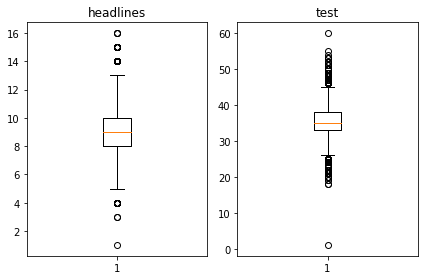

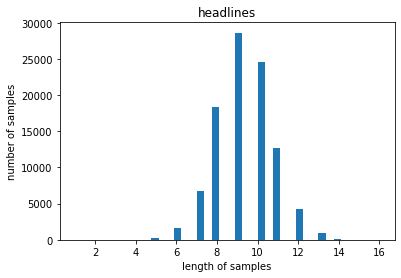

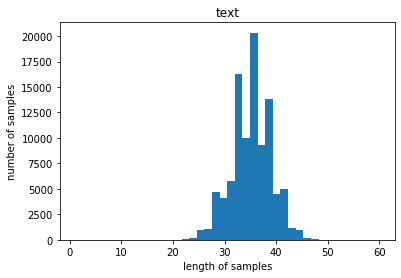

In [12]:
# text, headlines 데이터의 길이 정보 출력 및 시각화
text_len = [len(s.split()) for s in data['text']]
summary_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(summary_len)
plt.title('headlines')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('test')
plt.tight_layout()
plt.show()

plt.title('headlines')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [24]:
text_max_len = 45
headlines_max_len = 13

In [25]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [27]:
# text, headlines 각각 최대 길이 이하인 데이터가 몇 퍼센트인지 확인
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 45 이하인 샘플의 비율: 0.9967771451809678
전체 샘플 중 길이가 13 이하인 샘플의 비율: 0.9981699877999186


In [30]:
# 최대 길이보다 긴 데이터들 삭제
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 97863


In [13]:
# headlines 데이터에 토큰 추가
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...,sostoken have known hirani for yrs what if met...,have known hirani for yrs what if metoo claims...


In [14]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [15]:
# 훈련 데이터와 테스트 데이터 분리
n_of_val = int(len(encoder_input)*0.2)

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

훈련 데이터의 개수 : 78688
훈련 레이블의 개수 : 78688
테스트 데이터의 개수 : 19672
테스트 레이블의 개수 : 19672


In [16]:
# vocabulary 생성
src_tokenizer = Tokenizer()
src_tokenizer.fit_on_texts(encoder_input_train)

In [17]:
# vocabulary에서 등장 빈도가 낮은 단어를 제거하기 위한 코드

threshold = 6
total_cnt = len(src_tokenizer.word_index)
rare_cnt = 0
total_freq = 0
rare_freq = 0

for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 68202
등장 빈도가 5번 이하인 희귀 단어의 수: 44460
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 23742
단어 집합에서 희귀 단어의 비율: 65.1887041435735
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.026731822610445


In [18]:
# vocabulary의 크기를 src_vocab으로 제한
src_vocab = 23000
src_tokenizer = Tokenizer(num_words = src_vocab)
src_tokenizer.fit_on_texts(encoder_input_train)

In [19]:
# 정수 인코딩
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

print(encoder_input_train[:3])

[[6517, 6858, 8212, 9930, 8773, 1663, 1737, 1992, 1397, 625, 11733, 1746, 2318, 1294, 878, 22, 140, 1228, 1663, 8212, 2561, 604, 349, 950, 5073, 133, 3394, 2304, 1819, 1547, 2174, 8212, 210, 322, 1992, 2188, 62, 8494], [5454, 237, 1275, 1046, 542, 1438, 413, 20463, 599, 101, 2370, 222, 373, 345, 5547, 17, 2, 13685, 8495, 26, 20464, 3702, 2966, 2641, 20463, 4730, 101, 117, 17, 20463, 3528, 124, 2642, 542, 533, 100, 4485, 10390, 3683, 38, 14648, 21888, 11734, 2500], [25, 715, 819, 3, 692, 597, 270, 4682, 72, 222, 7, 88, 89, 88, 270, 144, 3, 262, 118, 88, 795, 235, 5404, 1300, 6518, 1306, 163, 409, 88, 1668, 3, 483, 2466, 2680, 323, 270, 115, 475]]


In [20]:
# decoder_input_train 데이터에서도 빈도가 낮은 단어 제거

tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

threshold = 6
total_cnt = len(tar_tokenizer.word_index)
rare_cnt = 0
total_freq = 0
rare_freq = 0

for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 29736
등장 빈도가 5번 이하인 희귀 단어의 수: 19412
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10324
단어 집합에서 희귀 단어의 비율: 65.28114070486953
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.570422008632134


In [21]:
# decoder_input_train과 decoder_target_train에서도 빈도가 낮은 단어를 제거하고, decoder_* 데이터들에 대해 정수 인코딩 적용

tar_vocab = 10000
tar_tokenizer = Tokenizer(num_words = tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 4974, 8739, 8740, 3, 730, 4, 9457, 1905, 9, 1147, 1148], [1, 26, 3676, 159, 243, 365, 14, 3030, 5, 123, 40, 7], [1, 41, 1236, 339, 453, 553, 487, 8, 160, 634, 3031], [1, 8152, 182, 8153, 1757, 499, 952, 1734, 849, 370], [1, 47, 2134, 2740, 5, 101, 148, 76, 960, 183, 78, 10, 2638, 611]]
target
decoder  [[4974, 8739, 8740, 3, 730, 4, 9457, 1905, 9, 1147, 1148, 2], [26, 3676, 159, 243, 365, 14, 3030, 5, 123, 40, 7, 2], [41, 1236, 339, 453, 553, 487, 8, 160, 634, 3031, 2], [8152, 182, 8153, 1757, 499, 952, 1734, 849, 370, 2], [47, 2134, 2740, 5, 101, 148, 76, 960, 183, 78, 10, 2638, 611, 2]]


In [22]:
# 빈도수가 낮은 단어를 제거하였으므로 이 과정에서 모든 단어가 제거되고 토큰만 포함한 것들을 제거

drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :',len(drop_train))
print('삭제할 테스트 데이터의 개수 :',len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 78688
훈련 레이블의 개수 : 78688
테스트 데이터의 개수 : 19672
테스트 레이블의 개수 : 19672


In [33]:
# 패딩 추가

encoder_input_train = pad_sequences(encoder_input_train, maxlen = text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen = headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen = headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = headlines_max_len, padding='post')

### 어텐션 메커니즘 사용하기 (추상적 요약)

In [38]:
# encoder(LSTM) 생성

embedding_dim = 128
hidden_size = 256

encoder_inputs = Input(shape=(text_max_len,))

enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [40]:
# decoder(LSTM) 생성
decoder_inputs = Input(shape=(None,))

dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])

decoder_softmax_layer = Dense(tar_vocab, activation = 'softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 45)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 45, 128)      2944000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 45, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [34]:
# 공개된 어텐션 메커니즘 다운로드
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")

('attention.py', <http.client.HTTPMessage at 0x7f673ac4a910>)

In [41]:
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])

decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 45)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 45, 128)      2944000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 45, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [42]:
# 모델 훈련

model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2)
history = model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 256, callbacks=[es], epochs = 50)

Epoch 1/50
308/308 [==============================] - 114s 370ms/step - loss: 5.2605 - val_loss: 4.7076
Epoch 2/50
308/308 [==============================] - 112s 362ms/step - loss: 4.6979 - val_loss: 4.3703
Epoch 3/50
308/308 [==============================] - 115s 373ms/step - loss: 4.3537 - val_loss: 4.1367
Epoch 4/50
308/308 [==============================] - 115s 375ms/step - loss: 4.1019 - val_loss: 3.9974
Epoch 5/50
308/308 [==============================] - 116s 375ms/step - loss: 3.9079 - val_loss: 3.8682
Epoch 6/50
308/308 [==============================] - 116s 376ms/step - loss: 3.7489 - val_loss: 3.7858
Epoch 7/50
308/308 [==============================] - 116s 376ms/step - loss: 3.6110 - val_loss: 3.6955
Epoch 8/50
308/308 [==============================] - 116s 376ms/step - loss: 3.4919 - val_loss: 3.6469
Epoch 9/50
308/308 [==============================] - 116s 376ms/step - loss: 3.3886 - val_loss: 3.5838
Epoch 10/50
308/308 [==============================] - 116s 377m

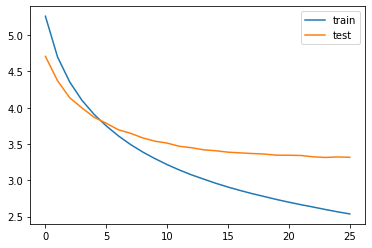

In [43]:
# 학습 시각화

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### 실제 결과와 요약문 비교하기 (추상적 요약)

In [44]:
# 정수 인덱스를 텍스트 데이터로 복구하기 위한 사전들 준비

src_index_to_word = src_tokenizer.index_word
tar_word_to_index = tar_tokenizer.word_index
tar_index_to_word = tar_tokenizer.index_word

In [45]:
# 추론을 위한 모델 설계

encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [49]:
def decode_sequence(input_seq):
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if(sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        e_h, e_c = h, c

    return decoded_sentence

In [50]:
# 정수 인덱스 시퀀스를 텍스트 데이터로 변환하기 위한 함수들 정의

def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

def seq2headlines(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [79]:
# 일부 데이터에 대한 추론 확인

for i in range(50):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2headlines(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : recent order bombay court held working woman capable maintaining sustaining entitled get maintenance estranged husband court observed hearing plea filed tv actress challenged family court order denied maintenance 
실제 요약 : working woman not entitled to maintenance bombay hc 
예측 요약 :  hc allows woman to be in court


원문 : total companies outstanding dues crore direct indirect taxes owed lakh crore approximately exchequer finance minister arun jaitley stated included one case service tax amount due crore added outstanding corporate dues lakh crore 
실제 요약 : companies owe dues worth over lakh crore 
예측 요약 :  banks crore crore in bank of crore


원문 : hong kong based startup origami labs developed smart ring called lets users talk phone placing ear ring transmit audio signals using bone technology priced around ring claims hour estimated talk time battery hours 
실제 요약 : smart ring lets users talk on phone through finger 
예측 요약 :  startup makes device that can see users in real time


원문 

예측 요약 :  russian firm to shut down as employees pay for


원문 : billionaire elon musk wednesday shared first ever video new startup boring company car elevator startup digging tunnels los angeles aims create underground network help cars avoid traffic cars taken underground via elevators moved desired destination using wheels kmph 
실제 요약 : elon musk shares first video of boring company car lift 
예측 요약 :  musk boring company to launch bike sharing startup


원문 : russian fooled us energy secretary rick perry believing discussing american coal exports pig manure ukrainian pm convinced perry ukrainian president petro poroshenko invented new biofuel made using pig manure home alcohol perry called idea interesting saying looked forward meeting poroshenko 
실제 요약 : russian dupe us official to talk about pig 
예측 요약 :  russia to create russian presidential trophy


원문 : tata steel closely following insolvency resolution process initiated banks acquire stressed assets dollar process insolvency res

예측 요약 :  sl end day of india after st test ton in yrs


원문 : village gujarat district holds annual event auction sewage water also makes revenue village low groundwater sewage water used irrigation purposes farming notably village first got idea auction three years back received revenue 
실제 요약 : gujarat village auctions sewage water yearly makes 
예측 요약 :  gujarat village gets electricity from bengaluru


원문 : lizard found veg biryani served passenger howrah delhi express train tuesday passenger ate biryani later discovered dead lizard tweeted complaint railway minister suresh prabhu incident comes amid cag report said food trains unfit human consumption 
실제 요약 : lizard found in biryani served to passenger on train 
예측 요약 :  passenger found in train accident in delhi


원문 : adobe tuesday announced stop updating distributing flash player plug end flash technology one widely used ways watch videos play games online recent years browsers google chrome microsoft edge safari flash favour alt

### 추출적 요약해보기

In [70]:
e_data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [94]:
for i in range(50):
    print("원문 :", e_data['text'][i])
    print("실제 요약 :", e_data['headlines'][i])
    print("예측 요약 :", summarize(e_data['text'][i], ratio=0.5))
    print("\n")

원문 : Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
실제 요약 : upGrad learner switches to career in ML & Al with 90% salary hike
예측 요약 : upGrad's Online Power Learning has powered 3 lakh+ careers.


원문 : Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.
실제 요약 : Delhi techie wins free food from Swiggy for one year on CRED
예측 요약 : Users get one CRED coin per rupee of bill pai

### 추상적 요약 vs. 추출적 요약
   
문장의 문법과 완성도 측면에서는 아무래도 이미 존재하는 문장들 중에 핵심 문장을 골라내는 추출적 요약이 더 완성도가 높았다.
다만 핵심 단어 포함 여부는 우열을 가리기 어렵다.   
추상적 요약은 우선 말이 안되는 문장이 꽤 있고, 그 결과 핵심 단어를 포함하지 못한 경우도 있었다.   
반면에 추출적 요약은 중심 문장을 뽑아내는 것이므로 말이 되고 핵심 단어를 포함하는 경우가 많았지만 문장 자체가 추출되지 않는 상황도 있었다.   
아마 지정한 ratio나 words의 인자 이내에 포함되는 길이의 문장이 없는 경우에 그런 것 같다.

### 회고

모델을 사용하는 것과 모델을 정확히 이해하는 것 사이의 어느정도에 학습 목표를 맞춰야 하는지에 대한 고민이 생겼다.   
어텐션 모듈은 기존 RNN 방식의 문제점인 gradient vanishing/explosion 및 long-tern dependencies 문제를 어느정도 해결할 수 있는 기술이며, 이의 기반이 되는 수학적인 배경과 내용은 절대 이해하기 쉽지 않았다.   
그럼에도 이번 노드에서 어텐션 레이어를 포함한 모델을 사용했고, 정확한 결과는 아니었지만 결론은 낼 수 있었다.   
확실하게 이해하지 못한 것을 사용하는 것은 항상 모든 상황에 의문을 낳는 것 같다.   
정확히 이해하는 것과 사용할 수 있는 것 그 사이의 어느 지점까지를 파악해야 하고 파고 들어야 하는지를 아직은 모르겠다.   